In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.spatial import KDTree


In [29]:
def line_intersection(line1, line2):
	"""
	Finds the intersection of two lines. Each line is defined by two points.
	Returns the intersection point (x, y) or None if lines are parallel.
	"""
	(x1, y1), (x2, y2) = line1
	(x3, y3), (x4, y4) = line2

	den = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
	if abs(den) < 1e-6:  # Use a small tolerance for floating point comparison
		return None  # Lines are parallel or collinear

	t_num = (x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)

	t = t_num / den
	
	intersect_x = x1 + t * (x2 - x1)
	intersect_y = y1 + t * (y2 - y1)
	
	return (intersect_x, intersect_y)

def get_internal_angle(p1, p2, p3):
	"""Calculates the internal angle at vertex p2, formed by p1-p2-p3."""
	v1 = np.subtract(p1, p2)
	v2 = np.subtract(p3, p2)
	
	cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
	
	# Clip for numerical stability and convert to degrees
	angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
	return angle

def is_reasonable_quad(ordered_points, min_angle=45, max_angle=135):
	"""
	Checks if a quadrilateral, defined by ordered points, has reasonable
	internal angles.
	"""
	angles = []
	num_points = len(ordered_points)
	if num_points != 4: 
		return False

	for i in range(num_points):
		p_prev = ordered_points[(i - 1 + num_points) % num_points]
		p_curr = ordered_points[i]
		p_next = ordered_points[(i + 1) % num_points]
		angle = get_internal_angle(p_prev, p_curr, p_next)
		angles.append(angle)
	
	return all(min_angle <= a <= max_angle for a in angles)

def find_loops(adjacency):
	"""
	Greedily searches for 4-line cycles, returning them as ordered paths.
	"""
	loops = []
	seen_loops = set()  # Tracks unique loops (represented as frozensets)
	for a in adjacency:
		for b in adjacency[a]:
			for c in adjacency[b]:
				if c == a: continue
				# We need a path a->b->c->d->a. A 3-cycle (a->b->c->a) is skipped.
				if a in adjacency[c]: continue
				for d in adjacency[c]:
					if d == a or d == b: continue
					if a in adjacency[d]:  # This closes the 4-line loop
						loop = (a, b, c, d)
						# Canonical representation to detect duplicates
						canonical_loop = frozenset(loop)
						if canonical_loop not in seen_loops:
							loops.append(loop)
							seen_loops.add(canonical_loop)
	return loops

def create_mask_from_loops(loops, segments, image_shape):
	"""
	Processes ordered loops to create a binary mask of valid quadrilaterals.
	"""
	mask = np.zeros(image_shape[:2], dtype=np.uint8)
	valid_rectangle_lines = set()
	
	for loop_indices in loops:  # e.g., (a, b, c, d)
		lines = [segments[i] for i in loop_indices]
		
		# 1. Find the 4 intersection points (vertices) from the ordered path
		v1 = line_intersection(lines[0], lines[1]) # Intersection of a & b
		v2 = line_intersection(lines[1], lines[2]) # Intersection of b & c
		v3 = line_intersection(lines[2], lines[3]) # Intersection of c & d
		v4 = line_intersection(lines[3], lines[0]) # Intersection of d & a
		
		vertices = [v for v in [v1, v2, v3, v4] if v is not None]
		
		# We need exactly 4 vertices to form a quadrilateral
		if len(vertices) != 4:
			continue
			
		# The vertices are already ordered by path traversal.
		ordered_vertices = np.array(vertices, dtype=np.int32)
		
		# 2. Validate the quad's shape using its internal angles
		if is_reasonable_quad(ordered_vertices):
			# 3. If valid, draw it on the mask and save the lines
			cv2.fillPoly(mask, [ordered_vertices], 1)
			valid_rectangle_lines.update(loop_indices)
			
	return mask, list(valid_rectangle_lines)

def get_keylines(image):
	# LSD Line Segment Detector
	lsd = cv2.line_descriptor.LSDDetector.createLSDDetector()
	keylines_raw = lsd.detect(image, scale=2, numOctaves=4)

	if keylines_raw is None or len(keylines_raw) < 4:
		return [], np.zeros(image.shape[:2], dtype=np.uint8)

	min_line_length = 10
	long_keylines = []
	segments = []

	for line in keylines_raw:
		p1 = np.array([line.startPointX, line.startPointY])
		p2 = np.array([line.endPointX, line.endPointY])
		length = np.linalg.norm(p1 - p2)
		
		if length > min_line_length:
			long_keylines.append(line)
			segments.append(((p1[0], p1[1]), (p2[0], p2[1])))
	points = [pt for seg in segments for pt in seg]

	print(f"Detected {len(segments)} line segments.")

	if len(segments) < 4:
		return [], np.zeros(image.shape[:2], dtype=np.uint8)

	# Build KDTree for fast proximity search
	kdtree = KDTree(points)

	# Build fast adjacency list based on endpoint proximity
	adjacency = defaultdict(set)
	for i, (p1, p2) in enumerate(segments):
		for p in [p1, p2]:
			# Find indices of points within a radius 'r'
			proximal_point_indices = kdtree.query_ball_point(np.array(p).reshape(1, -1), r=5.0)[0]
			for j in proximal_point_indices:
				# Map point index back to line index
				other_line_idx = j // 2
				if other_line_idx != i:
					adjacency[i].add(other_line_idx)
	
	# Find ordered loops of 4 lines
	loops = find_loops(adjacency)
	
	# Process loops to create a mask and get the lines of valid quads
	mask, rectangle_line_indices = create_mask_from_loops(loops, segments, image.shape)
	
	# Filtered output
	filtered_keylines = [keylines_raw[i] for i in rectangle_line_indices]
	
	return filtered_keylines, mask


Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-39.jpg
Detected 1287 line segments.


/var/folders/3r/fh3b19nj1wd7v7n3q7p6r9680000gn/T/ipykernel_3637/1508448962.py:27: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


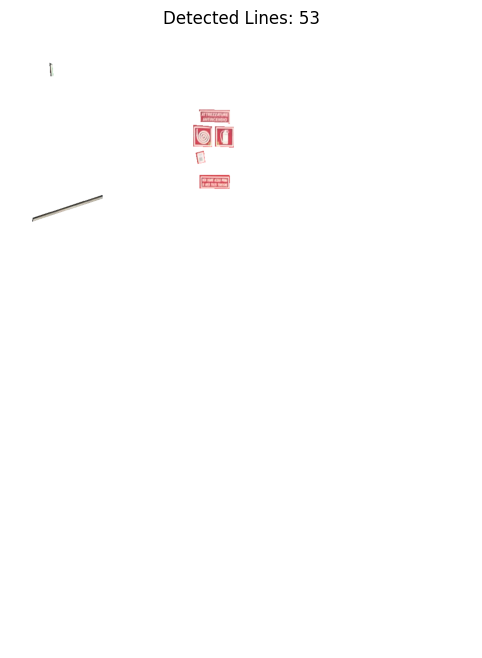

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00006.jpeg
Detected 3066 line segments.


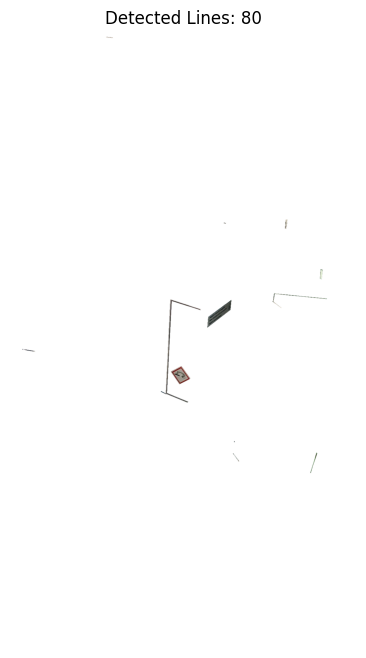

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00007.jpeg
No keylines found.
Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00016.jpg
Detected 653 line segments.


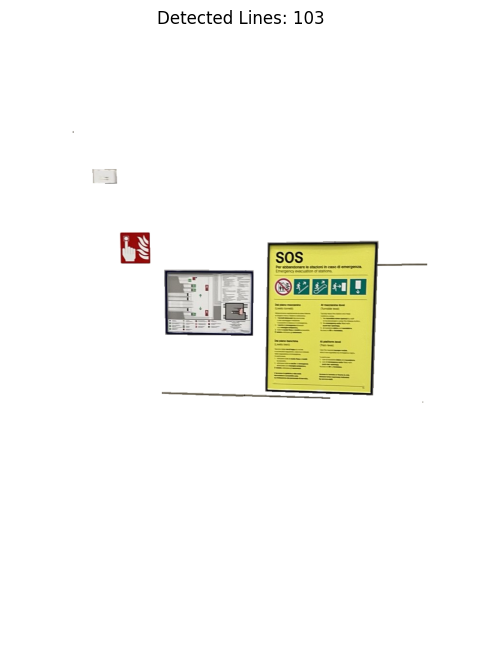

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00000.jpg
Detected 10838 line segments.


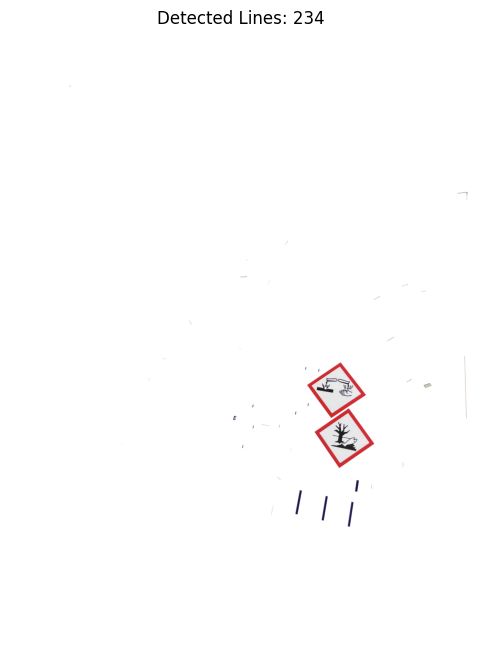

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00015.jpg
Detected 333 line segments.


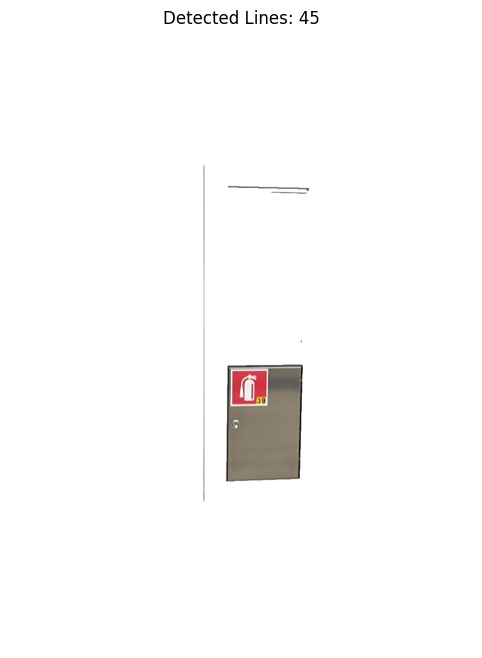

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00011.jpg
Detected 350 line segments.
No keylines found.
Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00010.jpg
Detected 277 line segments.


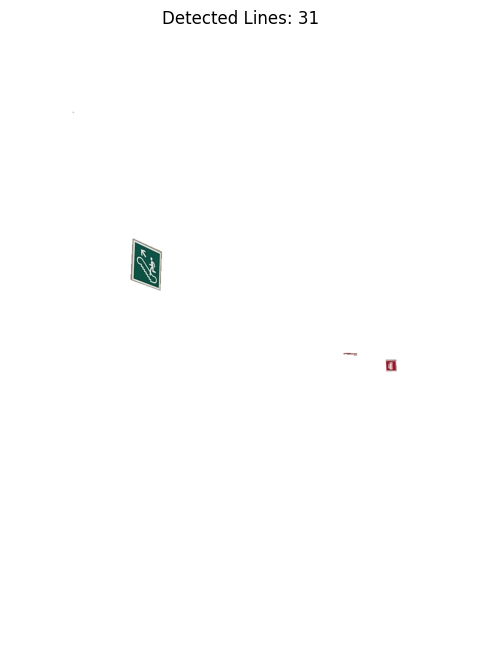

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00001.jpeg
Detected 885 line segments.


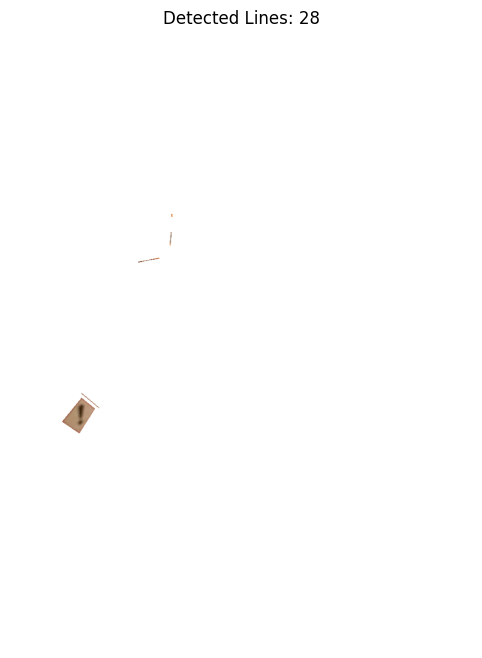

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00012.jpg
Detected 641 line segments.


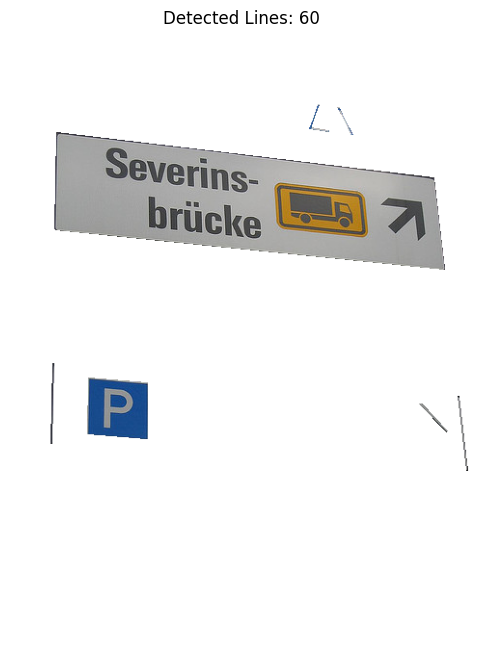

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00013.jpg
Detected 452 line segments.


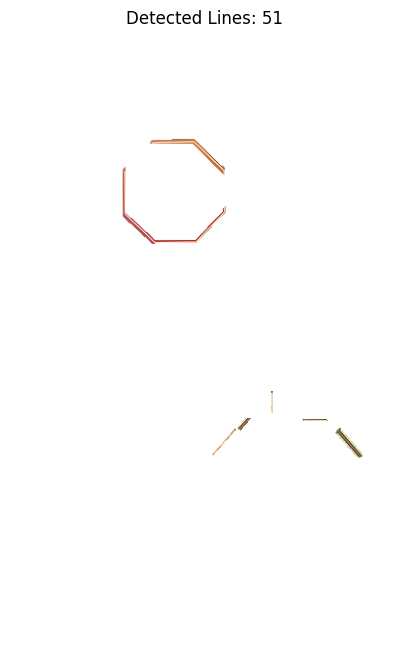

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00002.jpeg
Detected 841 line segments.


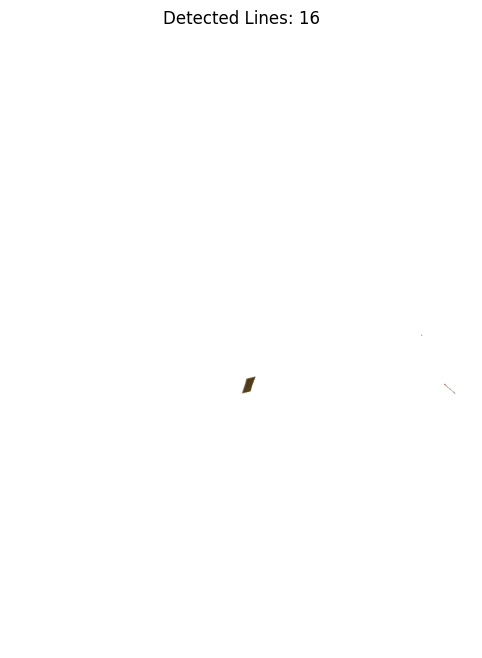

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-44.jpg
Detected 2997 line segments.


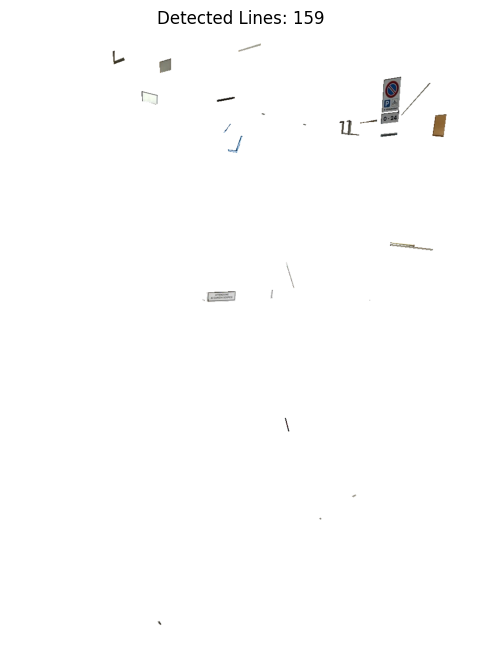

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-51.jpg
Detected 3243 line segments.


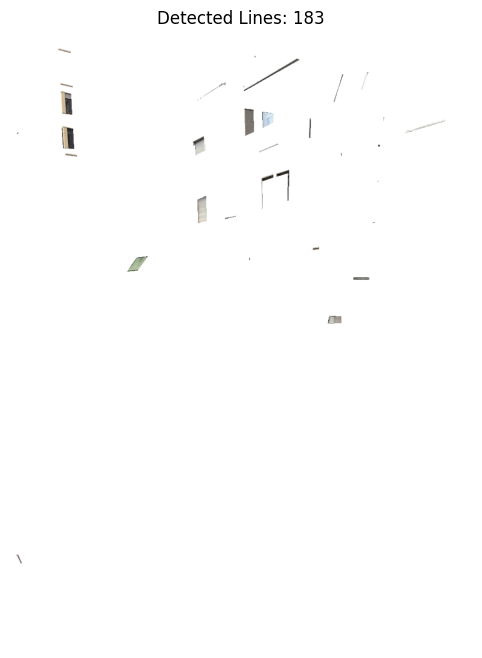

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-47.jpg
Detected 1166 line segments.


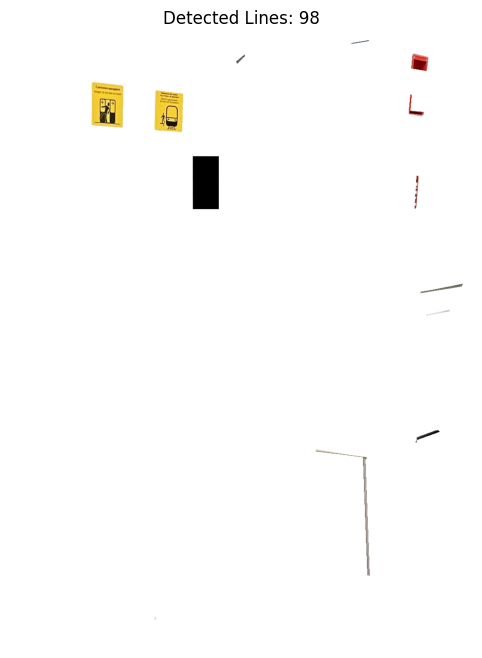

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/road185.png
Detected 439 line segments.


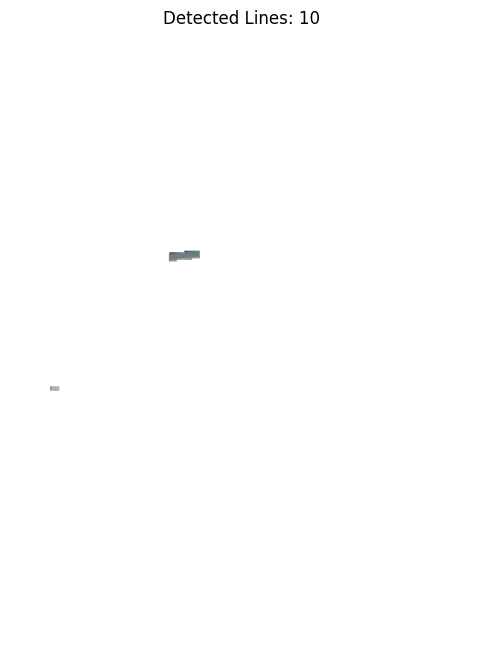

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00003.jpeg
Detected 1162 line segments.


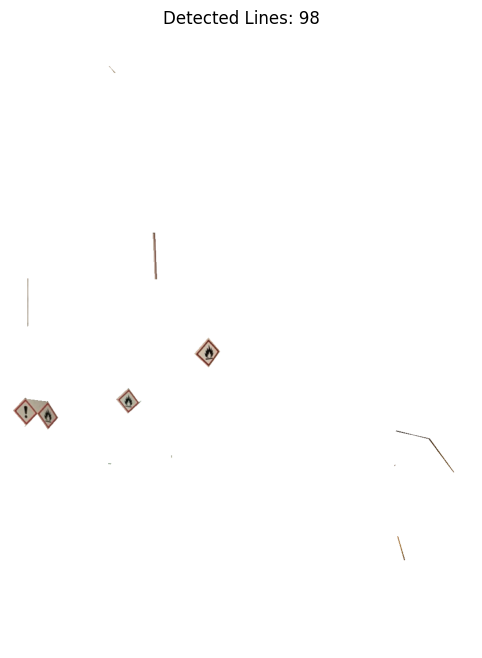

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00008.jpeg
Detected 1676 line segments.


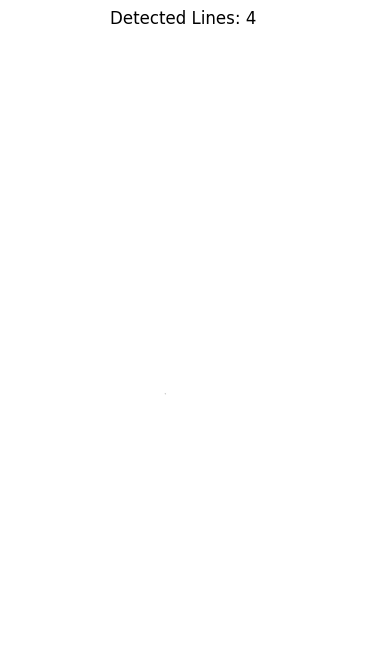

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00004.jpeg
Detected 1817 line segments.


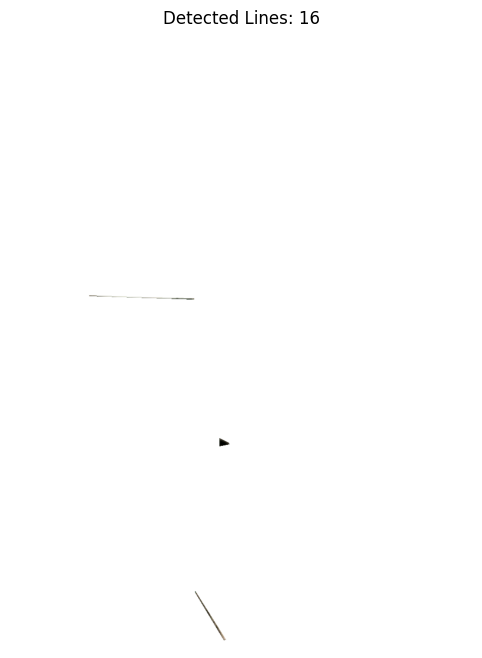

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00005.jpeg
Detected 1770 line segments.


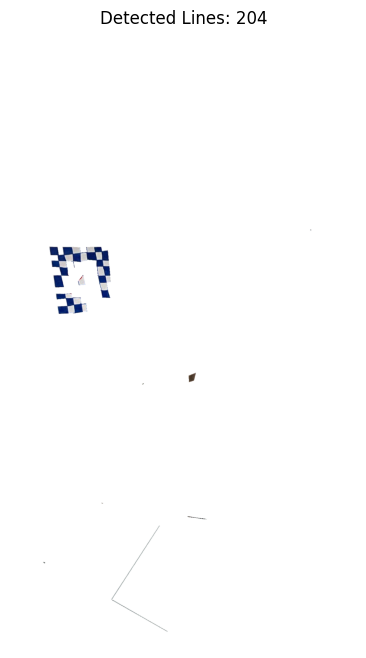

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00009.jpeg
Detected 4319 line segments.


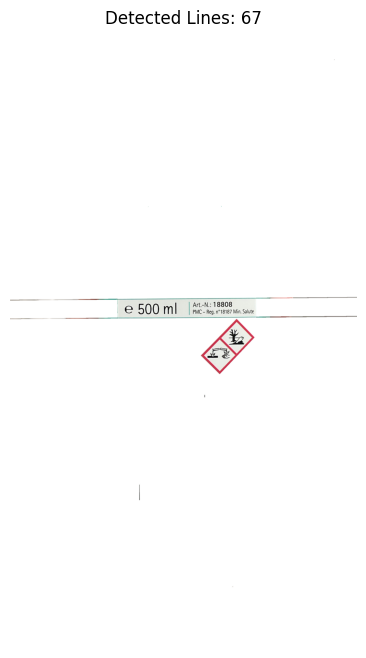

In [30]:
images_folder = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive"
image_paths = []
for root, dirs, files in os.walk(images_folder):
	for file in files:
		if file.lower().endswith(('.png', '.jpg', '.jpeg')):
			image_paths.append(os.path.join(root, file))

for image_path in image_paths:
	print(f"Processing {image_path}")
	
	image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

	# Get keylines
	filtered_keylines, mask = get_keylines(image)

	if not filtered_keylines:
		print("No keylines found.")
		continue

	img_with_lines = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

	# # Draw the detected keylines
	# for keyline in filtered_keylines:
	# 	pt1 = (int(keyline.startPointX), int(keyline.startPointY))
	# 	pt2 = (int(keyline.endPointX), int(keyline.endPointY))
	# 	cv2.line(img_with_lines, pt1, pt2, (0, 255, 0), 2)

	plt.figure(figsize=(12, 8))
	masked_img = img_with_lines.copy()
	masked_img[mask == 0] = [255, 255, 255]  # Set background to white where mask is 0
	plt.imshow(masked_img)
	plt.title(f'Detected Lines: {len(filtered_keylines)}')
	plt.axis('off')
	plt.show()

